# Demo code for Flow Matching


This demo code is adapted from [this code](https://github.com/dome272/Flow-Matching/blob/main/flow-matching.ipynb). However, I believe that the original implementation contains an error in the training phase. Therefore, I followed the original paper [(Lipman et al. 2022, arXiv:2210.02747)](https://arxiv.org/abs/2210.02747) and re-implemented the code from scratch.


### Basic intuition for flow matching. 
Consider samples at  t = 0  that follow a simple distribution. By designing a velocity field  u_t(x) , you move these samples so that at  t = 1  they match the complex data distribution.

The idea is shown in the following movie produced by XXX.

<video controls width="600">
    <source src="flow_matching_animation.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

[![Flow Matching Animation](Video)](flow_matching_animation.mp4)


## Flow Matching
Next, you use a network to learn the velocity field $v_t(x)$ that was designed for the samples. The network is trained by minimizing the loss function:

$$
    \mathcal{L}_{\tt FM} = \mathbb{E}_{x \sim p_t,\, t \sim U(0,1)} \left( \left\| v_t(x) - u_t(x) \right\|^2 \right)
$$

where:
- $x \sim p_t(x)$ denotes a sample from the distribution at time $t$ (also called the *probability path*).
- $u_t(x)$ is the target (designed) velocity field at time $t$.
- $v_t(x)$ is the predicted (learned) velocity field at time $t$.

As a side note, $u_t(x)$ and $p_t(x)$ are connected by the continuity equation:

$$
    \frac{\partial p_t}{\partial t} + \nabla \cdot \bigl(p_t \, u_t\bigr) = 0,
$$

which ensures that no mass is created or destroyed.


## Designing the velocity field
Note that, we have no idea how to design the velocity field. Instead of using the loss $\mathcal{L}_{\tt FM}$, we can condition on samples at $t = 1$ and use the following loss function $\mathcal{L}_{\tt CFM}$:

$$
\mathcal{L}_{\tt CFM} = \mathbb{E}_{x_1 \sim p(x_1),\, t \sim U(0,1),\, x \sim p_t(x \mid x_1)} \left( \left\| v_t(x) - u_t(x \mid x_1) \right\|^2 \right).
$$

Here:
- $x_1 \sim p(x_1)$ is a sample from the data distribution.
- $x \sim p_t(x \mid x_1)$ follows an interpolation path from noise to data given $x_1$.
- $u_t(x \mid x_1)$ is the target velocity field given $x_1$.

This formulation corresponds to Equation 9 in Lipman et al. (2022). The loss function $\mathcal{L}_{\tt CFM}$ and $\mathcal{L}_{\tt FM}$ are not equivalent, but taking the gradients relevant for the networks are the same.




### Super Crude Approach / Building Intuition

How can we define $u_t(x \mid x_1)$? At time $t$, being at position $x$ while needing to reach $x_1$ at $t = 1$, the remaining distance is $x_1 - x$ and the remaining time is $1 - t$. The velocity beging distance divided by time, yields:

$$
u_t(x \mid x_1) = \frac{x_1 - x}{1-t}.
$$

A linear interpolation from $x_0$ to $x_1$ would be $x_t = x_0 + t(x_1 - x_0)$. However, it is unclear how to derive $p_t(x \mid x_1)$ from the particles. It might be better to start with $p_t(x \mid x_1)$ and then derive $u_t(x \mid x_1)$.

### Correct Approach: Looking at Distributions

We must consider the probability path $p_t(x)$ rather than focusing on the particles. The animation below shows the probability path $p_t(x)$ at $t=0$ and $t=1$:

![Flow Animation](https://mlg.eng.cam.ac.uk/blog/assets/images/flow-matching/representative.gif)  

*Figure 1: Flow Matching Animation showing the evolution of samples over time (taken from [Flow Matching](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)).*

Since we cannot determine $p_t(x)$ directly, we instead use the conditional probability path $p_t(x \mid x_1)$. There are several options available.

**First,** assume a Gaussian distribution for $p_t(x \mid x_1)$:

$$
    p_t(x \mid x_1) = \mathcal{N}\Bigl(x \mid \mu_t(x_1),\, \sigma_t^2(x_1) I\Bigr).
$$

For a Gaussian distribution, it can be shown (Theorem 3 in Lipman et al. (2022)) that the corresponding velocity field is:

$$
   u_t(x \mid x_1) = \frac{\dot{\sigma}_t(x_1)}{\sigma_t(x_1)} \Bigl( x - \mu_t(x_1) \Bigr) + \dot{\mu}_t(x_1),
$$

with $\dot{\mu}_t(x_1)$ and $\dot{\sigma}_t(x_1)$ being the time derivatives.


**Second,** we can explicitly design $\mu_t$ and $\sigma_t$.

It turns out that diffusion models (i.e., score-based models) also fall into this category, though they often use a rather unintuitive choice for $\mu_t$ and $\sigma_t$ (see Lipman et al. (2022), Example 1, for more details).

A more straightforward choice (based on *optimal transport*) is to define:

$$
\mu_t(x_1) = t \, x_1,
$$

so that at $t = 0$ the mean is $0$ and at $t = 1$ it is $x_1$. We set $\sigma_0 = 1$ and $\sigma_1 = \sigma_{\min}$, and choose a linear interpolation:

$$
\sigma_t(x_1) = 1 - \bigl(1 - \sigma_{\min}\bigr) \, t.
$$

With this choice, the velocity field becomes:

$$
u_t(x \mid x_1) = \frac{x_1 - \bigl(1 - \sigma_{\min}\bigr)x_t}{1 - \bigl(1 - \sigma_{\min}\bigr) t}.
$$

Thus, the complete algorithm to approximate the loss $\mathcal{L}_{\tt CFM}$ is:

$$
\mathcal{L}_{\tt CFM} = \mathbb{E}_{x_1 \sim p(x_1),\, t \sim U(0,1),\, x \sim p_t(x \mid x_1)} \left( \left\| v_t(x) - u_t(x \mid x_1) \right\|^2 \right).
$$

1. Sample $x_1$ from the data distribution.
2. Sample $t$ from a uniform distribution $U(0,1)$.
3. Compute the target velocity field $u_t(x \mid x_1)$.
4. Calculate the difference between the predicted velocity field $v_t(x)$ and the target velocity field $u_t(x \mid x_1)$.

In pytorch see also below:

```python
for i in range(NUM_ITER):
    indices = torch.randint(data.size(0), (BATCH_SIZE,))
    x1 = data[indices]  # Shape: (BATCH_SIZE, data_dim)
    
    t = torch.rand(BATCH_SIZE, 1, device=x1.device)  # t ~ Uniform(0,1), Shape: (BATCH_SIZE, 1)
    mu = x1 * t  # Shape: (BATCH_SIZE, data_dim)
    sigma = 1 - (1 - SIGMA_MIN) * t  # Shape: (BATCH_SIZE, data_dim)
    x_t = mu + sigma * torch.randn_like(mu)  # x_t ~ N(mu, sigma^2) Shape: (BATCH_SIZE, data_dim)
    u_t = (x1 - (1 - SIGMA_MIN) * x_t) / (1 - (1 - SIGMA_MIN) * t)  # Target velocity
    # Model should predict the Target velocity
    pred = model(x_t, t) # Shape: (BATCH_SIZE, data_dim)
    loss = ((u_t - pred) ** 2).mean()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

```

Final note before we look at the code: What have we done? We do not know or have an idea how to choose the **unconditioned** probability path $p_t(x)$. But we have an idea how the **conditioned** probability path $p_t(x | x_1)$ should look like. 

This probability path induces a velocity field $u_t(x | x_1)$ and we can train a network to learn this velocity field **unconditionally**. So we use a network to infere the unconditional path. This is the basic idea of flow matching.   

## Imports and Data Generation

In [5]:
import numpy as np
import tqdm
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

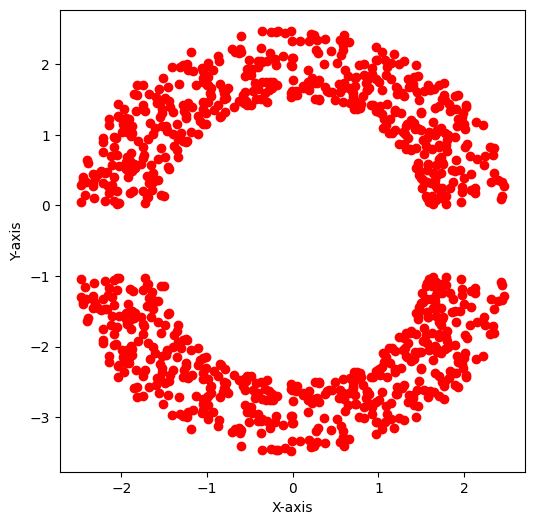

In [6]:
def generate_halfmoon_data(N, radius=2.0, width=1.0, distance=1.0):
    sampled_points = []

    while len(sampled_points) < N:
        # Random angle for a half-circle (upper moon)
        theta = np.random.uniform(0, np.pi)
        r = np.random.uniform(radius - width / 2, radius + width / 2)

        # Upper moon centered at (0, 0)
        x_sample = r * np.cos(theta)
        y_sample = r * np.sin(theta)

        sampled_points.append((x_sample, y_sample))

        if len(sampled_points) >= N:
            break

        # Lower moon centered at (0, -distance)
        x_sample = r * np.cos(theta)
        y_sample = -r * np.sin(theta) - distance

        sampled_points.append((x_sample, y_sample))

    # Convert to NumPy array
    sampled_points = np.array(sampled_points[:N])

    return sampled_points

# Parameters
N = 1000  # Number of points to sample
# Generate data
sampled_points = generate_halfmoon_data(N)
# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

## Model

In [7]:
import math
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[Block(channels) for _ in range(layers)])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10_000):
        """
        Generates sinusoidal time embeddings.
        t: (batch, 1) tensor of time steps.
        Returns: (batch, channels_t) tensor.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1) # Ensure shape (batch, 1)
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(float(max_positions) + 1e-8) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * -emb_scale)
        emb = t * emb  # (batch, half_dim)

        # Compute sinusoidal embeddings
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)  # (batch, channels_t)
        
        # If channels_t is odd, pad the embedding with zero
        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant', value=0)
        
        return emb

    def forward(self, x, t):
        """
        Forward pass of MLP.
        x: (batch, channels_data) input data.
        t: (batch, 1) time step input.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # Ensure shape (batch, 1)

        x = self.in_projection(x)  # (batch, channels)
        t_emb = self.gen_t_embedding(t)  # (batch, channels_t)
        t_emb = self.t_projection(t_emb)  # (batch, channels)

        x = x + t_emb  # Combine time and input embeddings
        x = self.blocks(x)
        x = self.out_projection(x)  # (batch, channels_data)

        return x

## Training 

In [8]:
import torch
import tqdm

# Constants
SIGMA_MIN = 1e-3
TRAINING_STEPS = 5_000
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

# Initialize model and optimizer
model = MLP(layers=5, channels=512)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Load data
data = torch.Tensor(sampled_points)

# Training loop
losses = []
pbar = tqdm.tqdm(range(TRAINING_STEPS), desc="Training Progress")

for _ in pbar:
    # Sample batch
    indices = torch.randint(data.size(0), (BATCH_SIZE,))
    x1 = data[indices]  # Shape: (BATCH_SIZE, data_dim)
    t = torch.rand(BATCH_SIZE, 1, device=x1.device)  # t ~ Uniform(0,1), Shape: (BATCH_SIZE, 1)
    mu = x1 * t  # Shape: (BATCH_SIZE, data_dim)
    sigma = 1 - (1 - SIGMA_MIN) * t  # Shape: (BATCH_SIZE, data_dim)
    x_t = mu + sigma * torch.randn_like(mu)  # x_t ~ N(mu, sigma^2) Shape: (BATCH_SIZE, data_dim)
    u_t = (x1 - (1 - SIGMA_MIN) * x_t) / (1 - (1 - SIGMA_MIN) * t)  # Target velocity
    # Model should predict the Target velocity
    pred = model(x_t, t) # Shape: (BATCH_SIZE, data_dim)
    loss = ((u_t - pred) ** 2).mean()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Logging
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

Training Progress: 100%|██████████| 5000/5000 [00:30<00:00, 166.33it/s, loss=1.81]


### Showing the training phase

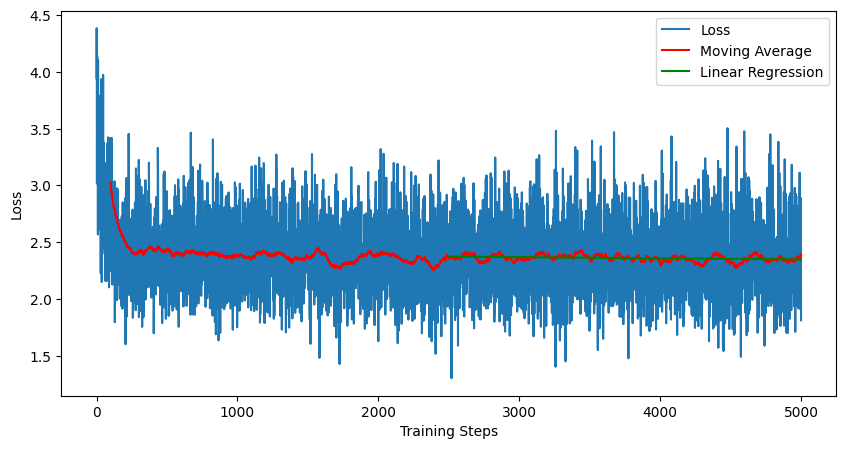

array([-1.00486557e-05])

In [9]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Calculate moving average
window_size = 100
losses_series = pd.Series(losses)
moving_avg = losses_series.rolling(window=window_size).mean()

# Plot the losses and moving average
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(moving_avg, label='Moving Average', color='red')

# Linear regression on the last 50% of the iterations
half_index = len(losses) // 2
x_vals = np.arange(half_index, len(losses)).reshape(-1, 1)
y_vals = losses[half_index:]

reg = LinearRegression().fit(x_vals, y_vals)
y_pred = reg.predict(x_vals)

plt.plot(x_vals, y_pred, label='Linear Regression', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()
reg.coef_

### Using Learned Velocity $v_t(x)$  

We now start with a set of particles $x_0 \sim \mathcal{N}(0, I)$ and evolve them by following the learned velocity field $v_t(x)$.  

Since the particles have **no mass or inertia**, they **immediately adjust** to the local velocity $v_t(x)$ at each step. This means that instead of having acceleration or momentum, they are simply carried along by the flow:  

$$
x_t = x_{t-1} + \delta \cdot v_t(x_{t-1}) 
$$

where $\delta = \frac{1}{\texttt{steps}}$ is a small time increment. This describes a process, where each particle moves exactly in the direction of the velocity field at every moment.  

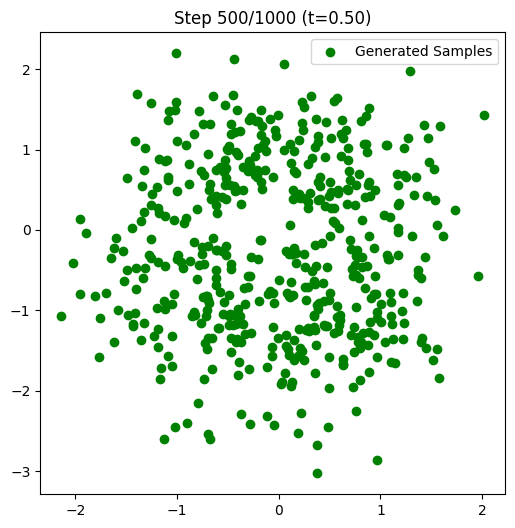

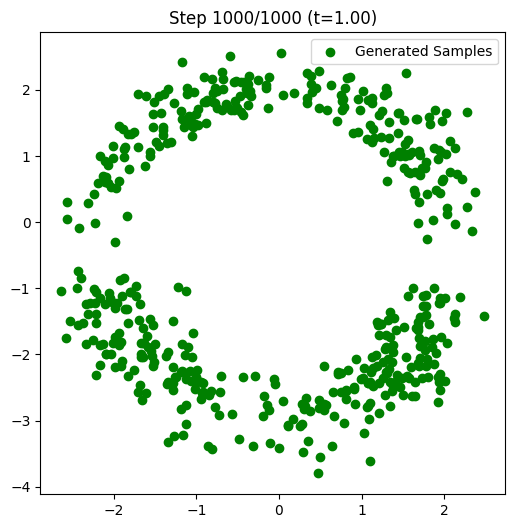

Done Sampling


In [10]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
xt = torch.randn(500, 2)
steps = 1000
plot_every = 500
with torch.no_grad():
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t = t.view(-1, 1).expand(xt.size(0), 1)  # Ensure (batch, 1) shape
        pred = model(xt, t)  # Predict velocity
        xt = xt + (1 / steps) * pred  
        
        # Plot results at intervals
        if i % plot_every == 0 or i == steps or i == 0:
            plt.figure(figsize=(6, 6))
            #plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Real Data")
            plt.scatter(xt[:, 0], xt[:, 1], color='green', marker="o", label="Generated Samples")
            plt.title(f"Step {i}/{steps} (t={t.mean().item():.2f})")
            plt.legend()
            plt.show()

# Restore model to training mode
model.train()
print("Done Sampling")

### Below is code for the animation

This is autogenerated code might not be so informative to understand flows.

In [14]:
import matplotlib.colors as mcolors
def assign_colors_by_polar_coordinates_with_brightness(points):
    """
    Assigns colors to points based on their polar coordinates.
    - Hue is determined by the angle (θ) from the positive x-axis.
    - Brightness (Value in HSV) is adjusted based on radius (smaller radius → darker).

    Parameters:
    - points: (N, 2) array of 2D points.
    
    Returns:
    - colors: (N, 3) RGB colors assigned based on angle and radius.
    """
    # Compute polar coordinates
    x, y = points[:, 0], points[:, 1]
    angles = np.arctan2(y, x)  # Angle in radians [-pi, pi]
    angles = (angles + np.pi) / (2 * np.pi)  # Normalize to [0,1] (hue)

    radii = np.sqrt(x**2 + y**2)  # Compute radius
    radii = (radii - radii.min()) / (radii.max() - radii.min() + 1e-6)  # Normalize to [0,1]
    brightness = 0.3 + 0.7 * radii  # Scale brightness (avoid too dark values)

    # Convert angle to hue in HSV color space
    hsv_colors = np.array([angles, np.ones_like(angles), brightness]).T  # HSV (hue, saturation, brightness)
    rgb_colors = mcolors.hsv_to_rgb(hsv_colors)  # Convert to RGB

    return rgb_colors


In [16]:
RUN_ANIMATION = False  # Set to True to run the animation
if RUN_ANIMATION:
    import matplotlib.animation as animation

    # Ensure computations are done on CPU (optional)
    torch.set_default_device("cpu")

    # Set random seed for reproducibility
    torch.manual_seed(42)
    model.eval()
    xt = torch.randn(1500, 2)
    colors = assign_colors_by_polar_coordinates_with_brightness(xt.numpy())
    steps = 1000
    plot_every = 5  # Increase frame rate for smooth animation
    fig, ax = plt.subplots(figsize=(6, 6))
    sc = ax.scatter(xt[:, 0], xt[:, 1], marker="o", c=colors, s=10)  # Initialize with x_0
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title("Flow Matching Dynamics")

    # Storage for animation frames
    trajectories = [xt.clone()]
    # Compute trajectories
    with torch.no_grad():
        for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
            t = t.view(-1, 1).expand(xt.size(0), 1)  # Ensure (batch, 1) shape
            pred = model(xt, t)  # Predict velocity
            xt = xt + (1 / steps) * pred
            if i % plot_every == 0:
                trajectories.append(xt.clone())

    # Update function for animation
    def update(frame):
        ax.set_title(f"Step {frame * plot_every}/{steps}")
        sc.set_offsets(trajectories[frame].numpy())  # Update positions

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(trajectories), interval=50)
    ani.save("flow_matching_animation.mp4", writer="ffmpeg")

    # Restore model to training mode
    model.train()

    print("Animation saved as flow_matching_animation.mp4")

## Better Integration

A better integration of the flow improves numerical stability and reduces discretization errors. Instead of using Euler integration (the methods above), which follows the simple update rule $x_t = x_{t-1} + \delta \cdot v_t(x_{t-1})$,

we can use higher-order numerical methods for more accurate trajectory reconstruction. These methods are available in Torch through the torchdiffeq library, which provides efficient ODE solvers.


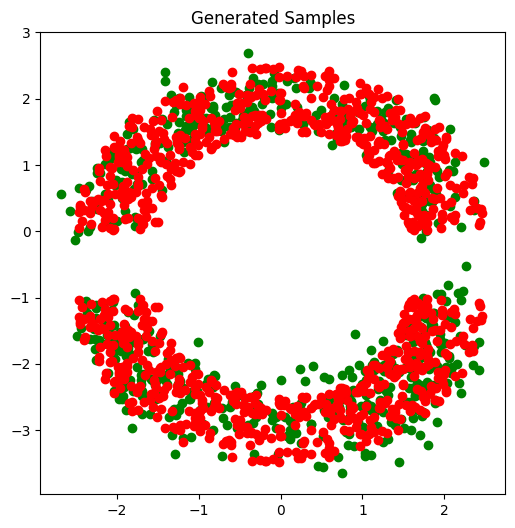

In [11]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_flow(model, x_0, steps=5, method="euler"):
    """
    Uses an ODE solver to integrate the learned velocity field.
    
    model: Neural network predicting v_t(x).
    x_0: Initial noise sample.
    steps: Number of integration steps.
    method: ODE solver method (e.g., "euler", "rk4", "dopri5", "bdf").
    
    Returns: Generated sample x_1.
    """
    def velocity_field(t, x_t):
        """
        Compute velocity at given time step.
        
        - t: Scalar time step.
        - x_t: Tensor of shape (batch_size, dim).
        """
        # Ensure x_t always has shape (batch_size, dim)
        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(0)  # Ensure batch size

        # Ensure t is a tensor of correct shape (batch_size, 1)
        t_tensor = torch.full((x_t.shape[0], 1), t.item(), device=x_t.device, dtype=x_t.dtype)

        # Compute velocity
        v_t = model(x_t, t_tensor)  # Ensure model output matches (batch_size, dim)
        return v_t

    # Define the time grid (descending order for reverse integration)
    t_eval = torch.linspace(0, 1, steps, device=x_0.device)

    # Solve the ODE using the chosen method
    x_trajectory = torchdiffeq.odeint(velocity_field, x_0, t_eval, method=method)

    # Return the final sample (last time step)
    x_1 = x_trajectory[-1]  # Shape: (batch_size, dim)

    return x_1

# Example: Generate samples using Euler method
x_0 = torch.randn(640, 2)  # Start from Gaussian noise
x_sampled = sample_flow(model, x_0, method="rk4")

# Plot the generated samples
plt.figure(figsize=(6, 6))
plt.scatter(x_sampled[:, 0].cpu(), x_sampled[:, 1].cpu(), color="green", marker="o")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Real Data")
plt.title("Generated Samples")
plt.show()
